# Evaluation

In [1]:
CONFIG_PATH = './configs/cpc-v1.json'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_confusion_matrix

from evaluate import load

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [4]:
model, history, model_evaluate, history_evaluate, test_gen = load(CONFIG_PATH)

Number of training batches: 2
Number of val batches: 1
Number of test batches: 1
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20480, 1)]        0         
_________________________________________________________________
cpc_encoder (CPCEncoder)     (None, 128, 512)          5260800   
_________________________________________________________________
autoregressive (Autoregressi (None, 256)               591360    
Total params: 5,852,160
Trainable params: 5,847,040
Non-trainable params: 5,120
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 20480, 1)]        0         
_________________________________________________________________
cpc_model (CPCM

In [5]:
def load_gen_in_memory(gen):
    X_test = []
    y_test = []
    for i in range(len(gen)):
        tmp = gen[i]
        X_test.extend(tmp[0])
        y_test.extend(tmp[1]) 
    return np.array(X_test), np.array(y_test)

# Load test_gen in memory
X_test, y_test = load_gen_in_memory(test_gen)
y_test_pred = np.argmax(model_evaluate.predict(X_test), axis=-1)

print(X_test.shape)
print(y_test.shape)
print(y_test_pred.shape)

(11, 20480, 1)
(11,)
(11,)


## Encoder (self-supervised training)

### Learning curves

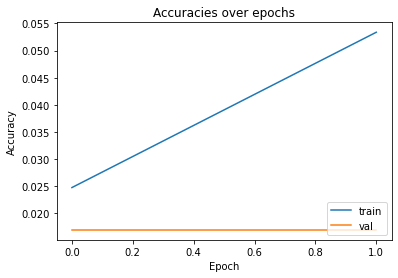

In [9]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Accuracies over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

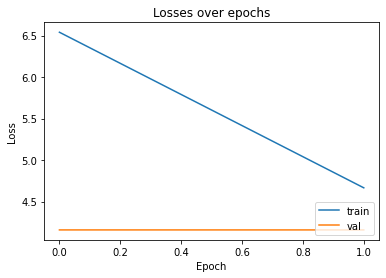

In [10]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Losses over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

### PCA on embeddings

In [27]:
def get_inputs(ids, nb_per_class):
    embeddings = []
    idx_class = 0
    for i in range(len(ids)):
        for j in range(len(X_test)):
            if y_test[j] == ids[i] and idx_class < nb_per_class:
                embeddings.append(X_test[j])
                idx_class += 1
        idx_class = 0
    return np.array(embeddings)

def plot_embeddings(classes, nb_per_class=6):
    inputs = get_inputs(classes, nb_per_class)
    
    assert len(inputs) == (len(classes) * nb_per_class)
    
    features = model(inputs)
    features = PCA(n_components=2).fit_transform(features)
    features = features.reshape((len(classes), nb_per_class, 2))

    # Plot
    plt.figure(figsize=(6, 6))
    for i in range(len(classes)):
        plt.plot(features[i, :, 0],
                 features[i, :, 1],
                 'o',
                 label="Class {}".format(classes[i]))
    plt.axis('off')
    plt.legend(numpoints=1)

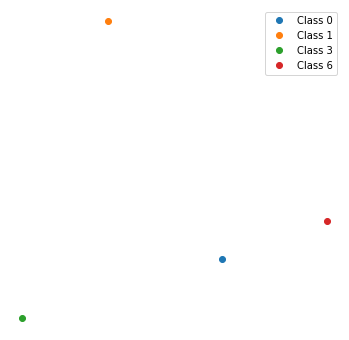

In [28]:
speakers = [0, 1, 3, 6]
plot_embeddings(speakers, nb_per_class=1)

## Speaker / language recognition

### Scores

In [29]:
model_evaluate.evaluate(X_test, y_test)

1/1 [==============================] - 1s 1s/step - loss: 2.6310 - accuracy: 0.0909


[2.6309814453125, 0.09090909361839294]

In [30]:
report = classification_report(y_test, y_test_pred, zero_division=0)
print(report)

              precision    recall  f1-score   support

         0.0       0.09      1.00      0.17         1
         1.0       0.00      0.00      0.00         2
         2.0       0.00      0.00      0.00         1
         3.0       0.00      0.00      0.00         2
         4.0       0.00      0.00      0.00         1
         6.0       0.00      0.00      0.00         1
         7.0       0.00      0.00      0.00         1
         8.0       0.00      0.00      0.00         2

    accuracy                           0.09        11
   macro avg       0.01      0.12      0.02        11
weighted avg       0.01      0.09      0.02        11



### Learning curves

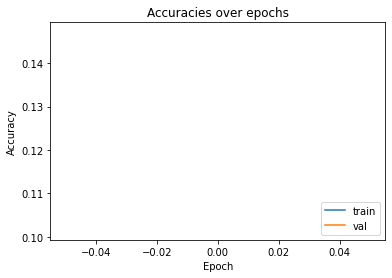

In [16]:
plt.plot(history_evaluate['accuracy'])
plt.plot(history_evaluate['val_accuracy'])
plt.title('Accuracies over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

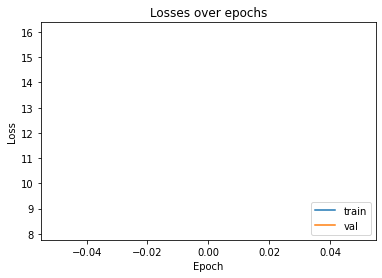

In [17]:
plt.plot(history_evaluate['loss'])
plt.plot(history_evaluate['val_loss'])
plt.title('Losses over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

### Confusion matrix

(<Figure size 432x432 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

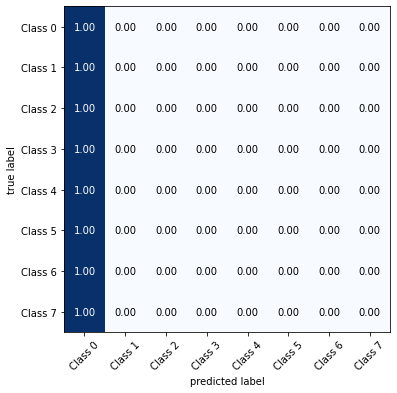

In [31]:
cm = confusion_matrix(y_test, y_test_pred)

nb_classes = len(np.unique(y_test))
class_names = ['Class {}'.format(i) for i in range(0, nb_classes)]

plot_confusion_matrix(cm,
                      colorbar=False,
                      show_normed=True,
                      show_absolute=False,
                      class_names=class_names,
                      figsize=(6, 6))

### Speaker recognition: error analysis

In [32]:
import glob
from IPython.display import display, Audio

def get_speaker_info(id, dataset_path):
    speakers = glob.glob(dataset_path + '/*')
    speaker = speakers[id]
    utterances = glob.glob(speaker + '/*/*.flac')
    utterance = utterances[0]
    return speaker.split('\\')[-1], utterance

def show_errors(count=3, dataset_path=''):
    idx_error = 0
    for i in range(len(X_test)):
        if y_test[i] != y_test_pred[i] and idx_error < count:
            idx_error += 1

            print('Error {}'.format(i))

            id, path = get_speaker_info(int(y_test_pred[i]), dataset_path)
            print('Predicted speaker: {}'.format(id))
            display(Audio(path))

            id, path = get_speaker_info(int(y_test[i]), dataset_path)
            print('Actual speaker: {}'.format(id))
            display(Audio(path))

            print('=' * 40)

In [33]:
show_errors(count=3,
            dataset_path='D:/Datasets/LibriSpeech/train-clean-100')

Error 1
Predicted speaker: 103


Actual speaker: 1034


Error 2
Predicted speaker: 103


Actual speaker: 1034


Error 3
Predicted speaker: 103


Actual speaker: 1040


## Speaker verification

In [26]:
import soundfile as sf
from pathlib import Path
from scipy.spatial.distance import cosine
from tensorflow.keras.layers import GlobalAveragePooling1D
from sklearn.preprocessing import normalize
from sklearn.metrics import roc_curve, det_curve

def get_frames(signal):
    signal_length = len(signal)
    frame_length = 20480
    frame_step = 20480

    num_frames = int(1 + np.ceil((signal_length - frame_length) / frame_step))

    zeros = np.zeros((num_frames * frame_length - signal_length))
    signal_padded = np.append(signal, zeros)

    indices_a = np.tile(np.arange(0, frame_length),
                        (num_frames, 1))
    indices_b = np.tile(np.arange(0, num_frames * frame_step, frame_step),
                        (frame_length, 1))
    indices = indices_a + indices_b.T

    frames = signal_padded[indices.astype(np.int32)]
    return frames

def evaluate_spk_verification(y, y_scores):
    # ROC curve
    fpr, tpr, thresholds = roc_curve(y, y_scores)
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.show()
    
    # DET curve
    fpr, fnr, thresholds = det_curve(y, y_scores)
    plt.title('DET curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('False Negative Rate')
    plt.plot(fpr, fnr)
    plt.show()
    
    eer_threshold = thresholds[np.nanargmin(np.absolute((fnr - fpr)))]
    eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
    print('Equal Error Rate (EER):', eer)
    
    y_pred = y_scores >= eer_threshold
    
    # Classification report
    report = classification_report(y, y_pred, zero_division=0)
    print(report)

    # Confusion matrix
    cm = confusion_matrix(y, y_pred)
    plot_confusion_matrix(cm,
                          colorbar=False,
                          show_normed=True,
                          show_absolute=False,
                          figsize=(3, 3))

def spk_verification(dataset_path, trial_list_path, limit=5):
    y = []
    y_scores = []

    with open(trial_list_path) as fp:
        line = fp.readline()
        count = 0

        while line and count != limit:
            target, path1, path2 = line.rstrip('\n').split(' ')

            data1, _ = sf.read(Path(dataset_path).joinpath(path1))
            data2, _ = sf.read(Path(dataset_path).joinpath(path2))
            
            # Split data in chunks of frame_length and
            # apply average pooling on resulting embeddings

            data1 = get_frames(data1)
            data2 = get_frames(data2)
            
            data1 = np.expand_dims(data1, axis=-1)
            data2 = np.expand_dims(data2, axis=-1)
            
            features1 = np.mean(model(data1), axis=0, keepdims=True)
            features2 = np.mean(model(data2), axis=0, keepdims=True)
            
            dist = 1.0 / cosine(normalize(features1), normalize(features2))
            y.append(int(target))
            y_scores.append(dist)

            count += 1
            line = fp.readline()

    return np.array(y), np.array(y_scores)

In [27]:
y, y_scores = spk_verification(dataset_path='D:/Datasets/vox1_test_wav/wav',
                               trial_list_path='./docs/voxcelebs_trial_list.txt',
                               limit=3)

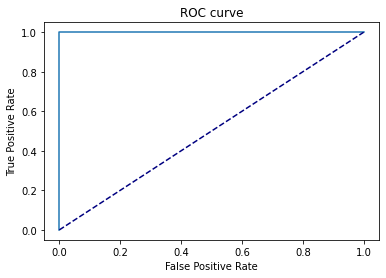

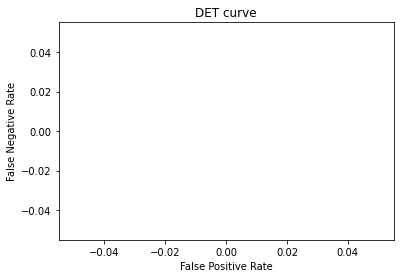

Equal Error Rate (EER): 0.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         2

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



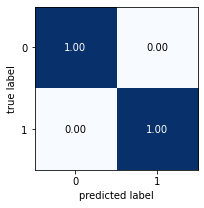

In [28]:
evaluate_spk_verification(y, y_scores)